## Token Merging for Stable Diffusion running with OpenVINO demo
This notebook demonstrates how to use Token Merging method to accelerate Stable Diffusion model running with OpenVINO. The method is applied to PyTorch model before exporting to OpenVINO representation.

In [1]:
import tomeov
from diffusers import StableDiffusionPipeline, DDPMScheduler
from diffusers.training_utils import set_seed
from optimum.intel.openvino import OVStableDiffusionPipeline
from IPython.display import display

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


/home/alex/virt_envs/stable_diffusion/lib/python3.8/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


OpenCLIP library is not available. Please install it to use Token Merging.


In [2]:
# scheduler = DDPMScheduler(beta_start=0.00085, beta_end=0.012,
#                           beta_schedule="scaled_linear", num_train_timesteps=1000)
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5") #"valhalla/sd-pokemon-model"
#pipe.safety_checker = lambda images, clip_input: (images, False)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [3]:
dir(tomeov)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'export_diffusion_pipeline',
 'import_utils',
 'is_diffusers_available',
 'is_openclip_available',
 'is_timm_available',
 'merge',
 'patch_stable_diffusion',
 'patch_timm',
 'stable_diffusion',
 'timm',
 'utils']

* Create a pipiline with Token Merging applied to a Stable Diffusion model and export it to OpenVINO representation.

In [4]:
# Apply ToMe with a 40% merging ratio
tomeov.patch_stable_diffusion(pipe, ratio=0.0) # Can also use pipe.unet in place of pipe here



StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
prompt = "astronaut riding on a horse"
set_seed(42)
output = pipe(prompt, num_inference_steps=50, output_type="pil")

  0%|          | 0/50 [00:00<?, ?it/s]

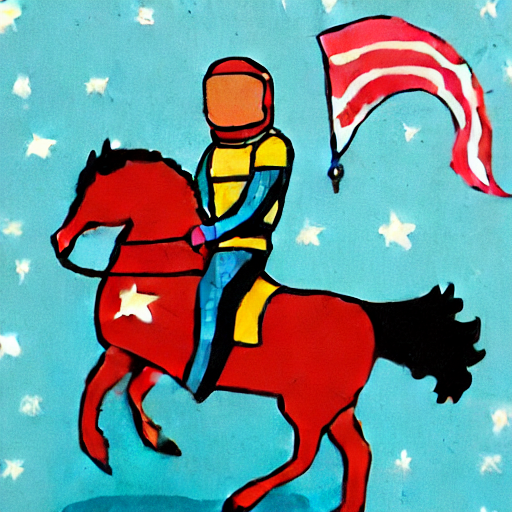

In [6]:
display(output.images[0])

In [7]:
save_dir = "stable_diffusion_optimized"
tomeov.export_diffusion_pipeline(pipe, save_dir)

/home/alex/virt_envs/stable_diffusion/lib/python3.8/site-packages/diffusers/models/cross_attention.py:51: FutureWarning: CrossAttnProcessor is deprecated and will be removed in `0.18.0`. Please use `from diffusers.models.attention_processor import AttnProcessor instead.
  deprecate("cross_attention", "0.18.0", deprecation_message, standard_warn=False)
Using framework PyTorch: 1.13.1+cu116
/home/alex/virt_envs/stable_diffusion/lib/python3.8/site-packages/nncf/torch/dynamic_graph/wrappers.py:74: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  op1 = operator(*args, **kwargs)
/home/alex/virt_envs/stable_diffusion/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:284: TracerWarning: Converting a tensor to a Python bool

* Create OpenVINO-based pipeline. We fix image size for faster inference.

In [8]:
set_seed(42)
ov_pipe = OVStableDiffusionPipeline.from_pretrained(save_dir, compile=False)
ov_pipe.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)
ov_pipe.compile()

The config attributes {'requires_safety_checker': True, 'safety_checker': ['stable_diffusion', 'StableDiffusionSafetyChecker']} were passed to OVStableDiffusionPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Compiling the encoder and creating the inference request ...
Compiling the encoder and creating the inference request ...
Compiling the encoder and creating the inference request ...


* Generate and display the image.

  0%|          | 0/51 [00:00<?, ?it/s]

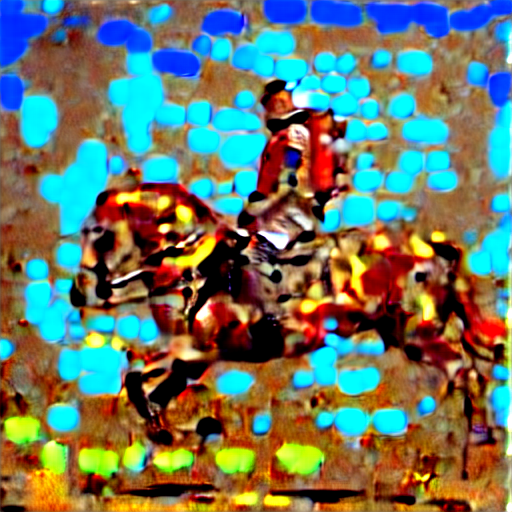

In [9]:
set_seed(42)
output = ov_pipe(prompt, num_inference_steps=50, output_type="pil")
display(output.images[0])